In [1]:
import juliacall  # has to be imported before torch to prevent segfault
from chirho.dynamical.handlers.solver import TorchDiffEq, DiffEqDotJL
from chirho.dynamical.ops import State, simulate
from chirho.dynamical.handlers import LogTrajectory
import torch
import time

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x0 = torch.tensor(10.).double().requires_grad_()
c = torch.tensor(1.).double().requires_grad_()
start, end = torch.tensor(0.), torch.tensor(11.)

def dynamics(s: State):
    return State(x=-s['x'] * s['c'])

def simulate_tend():
    sp0 = State(x=x0.double(), c=c)
    with LogTrajectory(torch.tensor([10.])) as lt:
        simulate(dynamics, sp0, start, end)
    return lt.trajectory['x'][-1]

In [3]:
torchdiffeq_times = []
with TorchDiffEq():
    for _ in range(100):
        exec_start_t = time.time()
        simulate_tend().backward()
        torchdiffeq_times.append(time.time() - exec_start_t)

In [4]:
diffeqdotjl_times = []
with DiffEqDotJL() as solver:
    for _ in range(100):
        exec_start_t = time.time()
        simulate_tend().backward()
        diffeqdotjl_times.append(time.time() - exec_start_t) 

  Activating project at `~/.julia/environments/diffeqpy`
/Users/azane/GitRepo/causal_pyro/chirho/dynamical/internals/backends/diffeqdotjl.py:117: UserWarning: A torch tensor is involved in an operation with a julia entity. This works by converting the torch tensor to a numpy array, but gradients will not  propagate to the torch tensor this way.For gradients to work, parameters of dynamics and event_fns need to appear in the initial_state passed to simulate.
  warnings.warn(


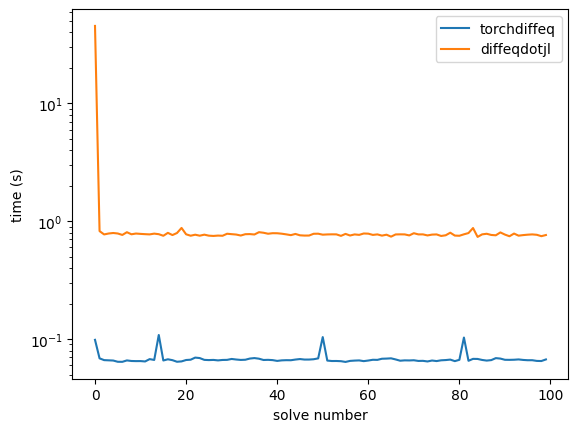

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(torchdiffeq_times, label='torchdiffeq') 
plt.plot(diffeqdotjl_times, label='diffeqdotjl')
plt.xlabel('solve number')
plt.ylabel('time (s)')
plt.yscale('log')
plt.legend()
plt.show()